In [1]:
# default_exp data.event_preprocessing

## Event  Preprocessing

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#export
from tsai.imports import *
from tsai.utils import * 
from tsai.data.validation import *

/home/doug/anaconda3/envs/tsai2/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
from tsai.data.synthetic import get_sample_data

# Code

In [5]:
#export
def _sliding_events(all_events, sig_lengths, width=100, offset=None, limit=None, include_empty=False):
    offset = offset if offset else -width//2
    offsetR = width + offset
    for i, events in enumerate(all_events):
        length = sig_lengths if isinstance(sig_lengths, int) else sig_lengths[i]
        events =  [e for e in events if e+offset >=0 and e+offsetR <  length]  # trim overlap
        if len(events) > 0:
            if limit and len(events) > limit:
                random.shuffle(events)
                events = events[:limit]
            for idx in events:
                yield i, idx+offset, idx+offsetR
        elif include_empty:
            idx = random.randint(sig_lengths[i]-width)
            yield i, idx, idx+width
        else:
            continue

In [6]:
#export
def _compute_new_splits(m, orig_splits):
    N = len(orig_splits)
    split_map = {i_orig:i_split for i_split, split in enumerate(orig_splits) for i_orig in split}
    return L([[i for i, i_orig in enumerate(m) if split_map[i_orig] == i_split]
              for i_split in range(N)])

In [7]:
#export
def _compute_new_folds(m, orig_folds):
    return np.array([orig_folds[i] for i in m])

In [8]:
#export
@delegates(_sliding_events)
def preprocess_sliding_event_window(X, y, events, splits=None, folds=None, **kwargs):
    """
Inputs:
      X: signal data, can be uniform or ragged, with or without channels 
      y: label data 
      events: List of event positions  for each signal  
      width: window size in samples
      offset: start of window vs event, window centered by default
      limit: max windows per signal, 
      include_empty: include randomly selected window if no events
      splits: splits data, will be mapped to windows data if present
      folds:  folds data, will be mapped to windows data if present
      *note: splits and folds are mutually exclusive
Returns:
      X_win: windows signals 
      y_win: labels for windowed signals
      folds_win or folds_win: Optional, depending on if splits or folds specified
"""
    sig_lengths = X.shape[-1] if len(X.shape) > 1  else [x.shape[-1] for x in X]
    X_win, y_win, m = zip(*[[X[i_orig][..., idx_l:idx_r], y[i_orig], i_orig]
        for (i_orig, idx_l, idx_r) in _sliding_events(events, sig_lengths, **kwargs)])
    
    if not isinstance(splits, NoneType):
        return np.array(X_win), y_win, _compute_new_splits(m, splits)
    elif not isinstance(folds, NoneType):
        return np.array(X_win), y_win, _compute_new_folds(m, folds)
    else:
        return np.array(X_win), y_win

# Examples and Tests

In [9]:
help(preprocess_sliding_event_window)

Help on function preprocess_sliding_event_window in module __main__:

preprocess_sliding_event_window(X, y, events, splits=None, folds=None, width=100, offset=None, limit=None, include_empty=False)
    Inputs:
          X: signal data, can be uniform or ragged, with or without channels 
          y: label data 
          events: List of event positions  for each signal  
          width: window size in samples
          offset: start of window vs event, window centered by default
          limit: max windows per signal, 
          include_empty: include randomly selected window if no events
          splits: splits data, will be mapped to windows data if present
          folds:  folds data, will be mapped to windows data if present
          *note: splits and folds are mutually exclusive
    Returns:
          X_win: windows signals 
          y_win: labels for windowed signals
          folds_win or folds_win: Optional, depending on if splits or folds specified



## test case: Uniform 1-d signal

X:(3, 1000)  y:3  events:3


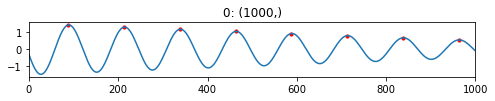

In [10]:
X, y, events = get_sample_data(length=1000, n_sig=3)
print(f'X:{X.shape}  y:{len(y)}  events:{len(events)}')
i, sig = 0, X[0]

plt.figure(figsize=(8, 1))
plt.title(f'{i}: {sig.shape}')
plt.plot(np.arange(len(sig)), sig)
plt.scatter(events[i], sig[events[i]], c='r', s=10)
plt.xlim(0, len(sig))
plt.show()

X_win:(15, 150)  y_win:15


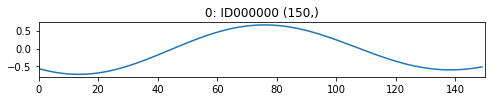

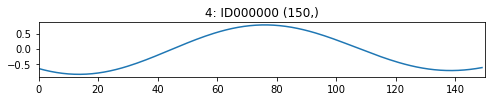

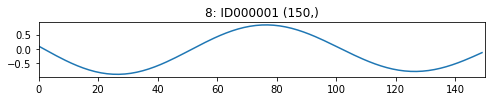

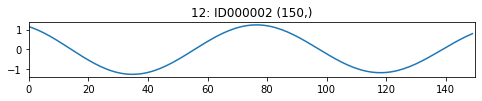

In [11]:
X_win, y_win = preprocess_sliding_event_window(X, y, events, width=150, limit=5)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')

for i in range(0, len(X_win), 4):
    sig = X_win[i]
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: {y_win[i]} {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.xlim(0, len(sig))
    plt.show()  

## Test case: Uniform 2-d signal

In [12]:
X, y, events = get_sample_data(length=1000, n_sig=3, dims=3)
print(f'X:{X.shape}  y:{len(y)}  events:{len(events)}')

X_win, y_win = preprocess_sliding_event_window(X, y, events, width=150, limit=5)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')

X:(3, 1, 1000)  y:3  events:3
X_win:(15, 1, 150)  y_win:15


## Test case: ragged 1d signal

X:(3,)  y:3  events:3


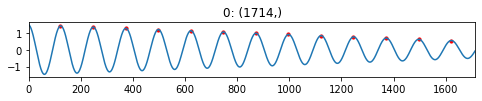

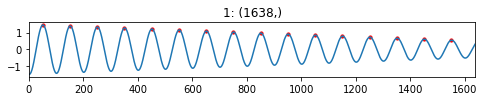

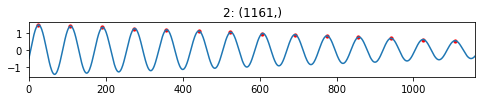

In [13]:
X, y, events = get_sample_data(length=(1000, 2000), n_sig=3)
print(f'X:{X.shape}  y:{len(y)}  events:{len(events)}')
for i, sig in enumerate(X):
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.scatter(events[i], sig[events[i]], c='r', s=10)
    plt.xlim(0, len(sig))
    plt.show()

X_win:(15, 150)  y_win:15


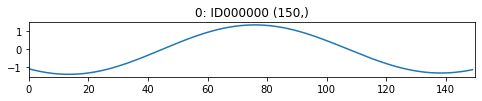

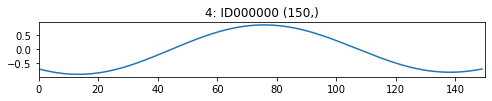

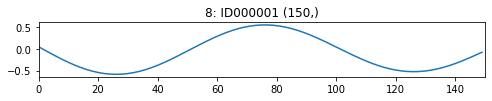

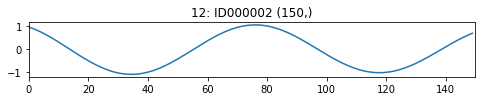

In [14]:
X_win, y_win = preprocess_sliding_event_window(X, y, events, width=150, limit=5)
print(f'X_win:{X_win.shape}  y_win:{len(y_win)}')
for i in range(0, len(X_win), 4):
    sig = X_win[i]
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: {y_win[i]} {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.xlim(0, len(sig))
    plt.show()    

## Test Case Splits

In [15]:
# generate data with splits
X, y, events, splits = get_sample_data(length=1000, n_sig=20, split_pct=(0.2, 0.15))
test_eq(len(splits), 3)
splits

(#3) [[0, 1, 2, 9, 10, 13, 14, 15, 16, 17, 18, 19],[4, 5, 6, 8],[3, 7, 11, 12]]

In [16]:
X_win, y_win, splits_win = preprocess_sliding_event_window(X, y, events, width=150, limit=2, splits=splits)
test_eq(len(splits_win), 3)
splits_win

(#3) [[0, 1, 2, 3, 4, 5, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],[8, 9, 10, 11, 12, 13, 16, 17],[6, 7, 14, 15, 22, 23, 24, 25]]

## Test Case Folds

In [17]:
# generate data with folds
X, y, events, folds = get_sample_data(length=1000, n_sig=20, n_fold=5)
folds

array([4, 2, 0, 1, 4, 4, 0, 0, 4, 1, 3, 1, 2, 3, 2, 3, 1, 2, 0, 3])

In [18]:
X_win, y_win, folds_win = preprocess_sliding_event_window(X, y, events, width=150, limit=2, folds=folds)
folds_win

array([4, 4, 2, 2, 0, 0, 1, 1, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 1, 1, 3, 3,
       1, 1, 2, 2, 3, 3, 2, 2, 3, 3, 1, 1, 2, 2, 0, 0, 3, 3])